In [1]:
import keras
from keras import layers
# from keras import ops
# from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
import tensorflow as tf
print(tf.__version__)

import numpy as np
import imageio, os
from gan_model import CGAN
from utils import generate_and_save_images
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import tqdm

import imgaug.augmenters as iaa
from keras.preprocessing.image import ImageDataGenerator

2.10.0



In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Defining the discriminator and generator architectures

In [3]:

def make_discriminator_model(discriminator_in_channels):
    # Create the discriminator.
    discriminator = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer((28, 28, discriminator_in_channels)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.GlobalMaxPooling2D(),
            layers.Dense(1),
        ],
        name="discriminator",
    )
    return discriminator

def make_generator_model(generator_in_channels):
# Create the generator.
    generator = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer((generator_in_channels,)),
            # We want to generate 128 + num_classes coefficients to reshape into a
            # 7x7x(128 + num_classes) map.
            layers.Dense(7 * 7 * generator_in_channels),
            layers.LeakyReLU(0.2),
            layers.Reshape((7, 7, generator_in_channels)),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    return generator

### Defining parameters

In [4]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
RANDOM_STATE=42

aug=False

In [5]:
model_path = "./gan_model/gan_model_.keras"
os.makedirs(model_path, exist_ok=True)
model_dir = os.path.dirname(model_path)

### Compiling the model

In [5]:
checkpoint_path = "training/gan.weights.h5"
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [21]:
cgan = CGAN(
    discriminator=make_discriminator_model(discriminator_in_channels), 
    generator=make_generator_model(generator_in_channels), latent_dim=latent_dim, 
    image_size=image_size, num_classes=num_classes,
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003),g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# cgan.compile(
#     d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
#     g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
#     loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# )

### Loading the data

In [7]:
import cv2
import random
random.seed(RANDOM_STATE)

aug_seq = iaa.Sequential([
            iaa.Rotate((-15, 15), random_state=RANDOM_STATE),                 
            # iaa.ShearX((-10, 10), random_state=RANDOM_STATE),                  
            # iaa.ShearY((-10, 10), random_state=RANDOM_STATE),
        ])


def augment(image):
    img_dim = 28
    kernel = np.ones((2, 2), np.uint8) 
    # if random.random() < 0.5:
    #     image = cv2.erode(image, kernel, iterations=1) 
    # else:
    #     image = cv2.dilate(image, kernel, iterations=1) 
    # if random.random() <= 0.9:
    #     Cx , Cy = 28, 28 #center of rotation
    #     rand_angle = random.randint(-10,10) #random angle range
    #     M = cv2.getRotationMatrix2D((Cy//2, Cx//2), rand_angle , 1) #center angle scale
    #     image  = cv2.warpAffine(image, M, (img_dim, img_dim))
    
    # if random.random() <= 0.5:
    #     shear_fac = random.randint(-3,3) / 10
    #     M = np.float32([[1, shear_fac, 0], [0, 1, 0]]).astype(np.float64)
    #     image = cv2.warpAffine(image, M, (img_dim, img_dim))
    
    # if random.random() <= 0.5:
    #     shear_fac = random.randint(-3,3) / 10
    #     M = np.float32([[1, 0, 0], [shear_fac, 1, 0]]).astype(np.float64)
    #     image = cv2.warpAffine(image, M, (img_dim, img_dim))

    image = aug_seq.augment_image(image)
    return image

C:\Users\Lisa\AppData\Local\Temp\ipykernel_11792\1929739733.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=[i for i in range(10)])


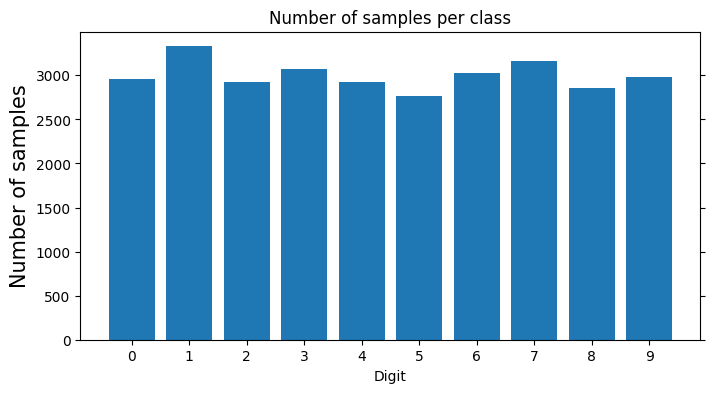

Number of training samples: 27000
Number of validation samples: 3000
Number of testing samples: 10000


In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
_, x_train, _, y_train = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

plt.rcParams['figure.figsize'] = [8, 4]
fig, ax = plt.subplots(nrows=1, ncols=1)

unique, counts = np.unique(y_train, return_counts=True)

barWidth = 0.2
br1 = np.arange(len(counts)) 

ax.bar(br1, counts)
ax.set_xticklabels(labels=[i for i in range(10)])
ax.tick_params(left = True, right = True , labelleft = True , 
                labelbottom = True, bottom = True) 
plt.xticks([r  for r in range(len(counts))])
plt.ylabel('Number of samples', fontsize = 15) 
plt.xlabel('Digit')
plt.title('Number of samples per class')
plt.show()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train) 

print("Number of training samples:", len(x_train))
print("Number of validation samples:", len(x_val))
print("Number of testing samples:", len(x_test))

# all_digits = np.concatenate([x_train, x_test])
# all_labels = np.concatenate([y_train, y_test])

In [9]:
import matplotlib.pyplot as plt

def plot_mnist_samples(data, f_name):
    plt.rcParams['figure.figsize'] = [6, 6]
    f, axarr = plt.subplots(5,5)

    idx = 0
    for i_row in range(5):
        for j_col in range(5):
            img = data[idx]
            axarr[i_row][j_col].imshow(img, cmap='gray')
            idx += 1
            axarr[i_row][j_col].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    plt.savefig(f_name, dpi=300)
    plt.show()

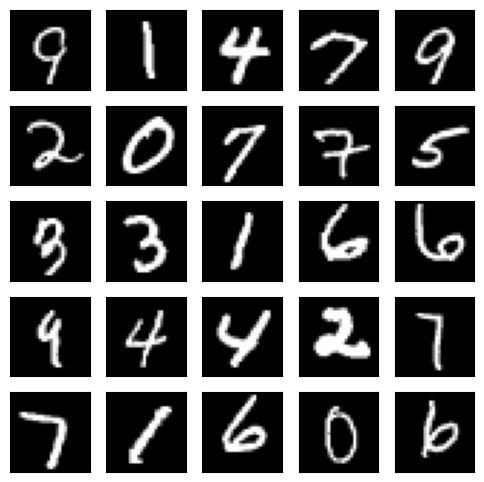

In [11]:
plot_mnist_samples(x_train, 'mnist_samples.png')

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 2660,
 1: 2996,
 2: 2628,
 3: 2769,
 4: 2637,
 5: 2490,
 6: 2720,
 7: 2842,
 8: 2571,
 9: 2687}

### Preprocessing

* Rescaling to [0-1]
* 1-hot encoding of labels
* augmentation (rotation, shearing)

In [11]:
if aug:
    x_train_aug = np.asarray([augment(x) for x in x_train.astype("float32")])
    plot_mnist_samples(x_train_aug, 'mnist_samples_aug.png')
    x_train_aug = x_train_aug.astype("float32") / 255.0

In [12]:
x_train = x_train.astype("float32") / 255.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


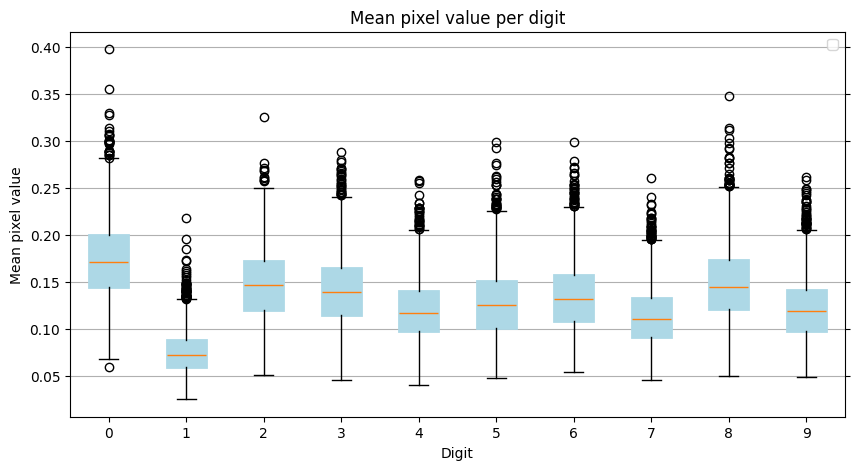

In [13]:
means_dict = {}
for i in range(10):
    means_dict[i] = []

for idx in range(len(x_train)):
    img =  x_train[idx]
    label = y_train[idx]
    means_dict[label].append(np.mean(img))


plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots(nrows=1, ncols=1)
box = ax.boxplot([means_dict[i] for i in range(10)], patch_artist=True)
for box_ in box['boxes']:
    box_.set(color='lightblue', linewidth=2)
    box_.set(facecolor = 'lightblue' )

ax.set_ylabel('Mean pixel value')
ax.set_xlabel('Digit')
ax.set_title('Mean pixel value per digit')
ax.set_xticklabels(labels=[i for i in range(10)])
ax.tick_params(left = True, right = True , labelleft = True , 
                labelbottom = True, bottom = True) 
plt.legend()
plt.grid(axis = 'y')
plt.savefig('mnist_gan_boxplot.png', dpi=300)
plt.show()

In [14]:
if aug:
    x_train = np.concatenate([x_train, np.array(x_train_aug)])
    y_train = np.concatenate([y_train, y_train])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


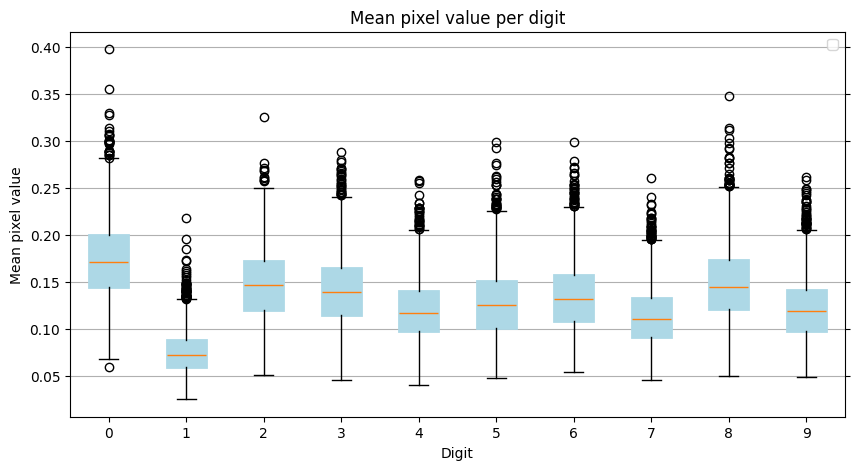

In [15]:
means_dict = {}
for i in range(10):
    means_dict[i] = []

for idx in range(len(x_train)):
    img =  x_train[idx]
    label = y_train[idx]
    means_dict[label].append(np.mean(img))

plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots(nrows=1, ncols=1)
box = ax.boxplot([means_dict[i] for i in range(10)], patch_artist=True)
for box_ in box['boxes']:
    box_.set(color='lightblue', linewidth=2)
    box_.set(facecolor = 'lightblue' )

ax.set_ylabel('Mean pixel value')
ax.set_xlabel('Digit')
ax.set_title('Mean pixel value per digit')
ax.set_xticklabels(labels=[i for i in range(10)])
ax.tick_params(left = True, right = True , labelleft = True , 
                labelbottom = True, bottom = True) 
plt.legend()
plt.grid(axis = 'y')
plt.savefig('mnist_gan_boxplot_aug.png', dpi=300)
plt.show()

In [16]:
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_val = x_val.astype("float32") / 255.0
x_val = np.reshape(x_val, (-1, 28, 28, 1))
y_val = tf.keras.utils.to_categorical(y_val, 10)

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {x_train.shape}")
print(f"Shape of training labels: {y_train.shape}")

Shape of training images: (27000, 28, 28, 1)
Shape of training labels: (27000, 10)


### Training the models

In [18]:
def save_img_on_epoch_end(epoch):
    os.makedirs("./results/gan_imgs/", exist_ok=True)
    labels = [i%10 for i in range(100)]
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes)

    # Sample random points in the latent space.
    random_latent_vectors = tf.random.normal(
        shape=(100, latent_dim), seed=1337
    )

    random_vector_labels = tf.concat(
        [random_latent_vectors, one_hot_labels], axis=1
    )

    predictions = cgan.generator(random_vector_labels, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(10,10, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('./results/gan_imgs/image_at_epoch_{:04d}_aug.png'.format(epoch))
    plt.close()


In [19]:
import tensorflow_gan as tfgan
import tqdm

val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_set = val_set.shuffle(buffer_size=1024).batch(len(x_val)//15)

def calc_metrics(gen_model):
    fid_score = 0.0
    inc_score = 0.0
    
    for batch in tqdm.tqdm(val_set):
        
        real_images, one_hot_labels = batch
        print(len(real_images))

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[cgan.image_size * cgan.image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, cgan.image_size, cgan.image_size, cgan.num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, cgan.latent_dim), seed=cgan.seed
        )

        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = gen_model(random_vector_labels, training=False)

        # real_images = tf.image.resize(real_images, [299, 299], method=tf.image.ResizeMethod.BILINEAR)
        # fake_images = tf.image.resize(generated_images, [299, 299], method=tf.image.ResizeMethod.BILINEAR)

        real_tensor = tf.concat((real_images, real_images), axis=3)
        real_tensor = tf.concat((real_tensor, real_images), axis=3)

        fake_tensor = tf.concat((generated_images, generated_images), axis=3)
        fake_tensor = tf.concat((fake_tensor, generated_images), axis=3)

        fid_score += tfgan.eval.frechet_inception_distance(real_tensor, fake_tensor, num_batches=len(batch))
        inc_score += tfgan.eval.inception_score(fake_tensor, num_batches=len(batch))

    print("FID:", fid_score/len(val_dataset))
    print("IS:", inc_score/len(val_dataset))
    return  fid_score/len(val_dataset), inc_score/len(val_dataset)

In [22]:
epochs = 200
# cgan.compiled_metrics == None
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_g_loss', patience=20)
eval_epoch = 25

# history = cgan.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback, save_img_callback])
history = {"d_loss": [], "g_loss":[], "val_d_loss":[], "val_g_loss":[], "val_fid": [], "val_fid":[], "val_inc":[]}
for epoch in range(epochs):
    g_loss = 0.0
    d_loss = 0.0
    for batch in train_dataset:
        res = cgan.train_step(batch)
        g_loss += res['g_loss'].numpy()
        d_loss += res['d_loss'].numpy()
    history["d_loss"].append(d_loss/len(train_dataset))
    history["g_loss"].append(g_loss/len(train_dataset))

    val_g_loss = 0.0
    val_d_loss = 0.0

    for batch in val_dataset:
        val_res = cgan.test_step(batch)
        val_g_loss += val_res['g_loss'].numpy()
        val_d_loss += val_res['d_loss'].numpy()

    history["val_d_loss"].append(val_d_loss/len(val_dataset))
    history["val_g_loss"].append(val_g_loss/len(val_dataset))

    
    print("epoch:", epoch, "d_loss:", history["d_loss"][epoch], "g_loss:", history["g_loss"][epoch], "val_d_loss:", history["val_d_loss"][epoch], "val_g_loss:", history["val_g_loss"][epoch])
    if (epoch + 1) % 5 == 0:
        save_img_on_epoch_end(epoch)

    if (epoch + 1) % eval_epoch == 0:
        cgan.generator.save(f'./mnist_gan_{epoch}_aug.keras')
        # fid, inc = calc_metrics(cgan.generator)
        # history["val_fid"].append(fid)
        # history["val_inc"].append(inc)

        



epoch: 0 d_loss: 0.4585974765191146 g_loss: 1.4969356360876165 val_d_loss: 0.28712230033062874 val_g_loss: 1.555507167856744
epoch: 1 d_loss: 0.4131155146806726 g_loss: 1.5362108533416314 val_d_loss: 0.33789306815634385 val_g_loss: 1.5660945202441925
epoch: 2 d_loss: 0.43227829081469804 g_loss: 1.478872229137692 val_d_loss: 0.8625331140579061 val_g_loss: 0.7389672626840308
epoch: 3 d_loss: 0.4482681284442332 g_loss: 1.4488984552604893 val_d_loss: 0.28422904712088565 val_g_loss: 1.4871130674443347
epoch: 4 d_loss: 0.4509697442088647 g_loss: 1.443215250968933 val_d_loss: 0.5343640947595556 val_g_loss: 1.2357483341338786
epoch: 5 d_loss: 0.44746785466139916 g_loss: 1.455747095047015 val_d_loss: 0.5243480503559113 val_g_loss: 1.1892990469932556
epoch: 6 d_loss: 0.44134611364507 g_loss: 1.480100672674405 val_d_loss: 0.1068487674631971 val_g_loss: 2.5585179430373173
epoch: 7 d_loss: 0.43100043848792524 g_loss: 1.520714611238778 val_d_loss: 0.3739676190183518 val_g_loss: 1.6792807249312705
ep

In [22]:
cgan_gen = tf.keras.models.load_model('./mnist_gan_199.keras')
fid, inc = calc_metrics(cgan_gen)

  0%|          | 0/15 [00:00<?, ?it/s]

200
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


In [ ]:
cgan_gen = tf.keras.models.load_model('./mnist_gan_199_aug.keras')
fid, inc = calc_metrics(cgan_gen)

In [23]:
print(history.history)

AttributeError: 'dict' object has no attribute 'history'

In [ ]:
# cgan.generator.save('./mnist_gan.keras')

### Generating images

In [ ]:
# cgan = tf.keras.models.load_model('./gan_model/mnist_gan.keras')
import tensorflow_gan as tfgan
labels = [i%10 for i in range(100)]
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes)
print(tf.shape(one_hot_labels))

# Sample random points in the latent space.
random_latent_vectors = tf.random.normal(
    shape=(100, latent_dim), seed=1337
)
print(tf.shape(random_latent_vectors))

random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

predictions = cgan.generator(random_vector_labels, training=False)

print(tf.shape(random_latent_vectors))

# Generate after the final epoch
# generate_and_save_images(cgan,
#                         epochs,
#                         random_vector_labels)

tf.Tensor([100  10], shape=(2,), dtype=int32)
tf.Tensor([100 128], shape=(2,), dtype=int32)
tf.Tensor([100 128], shape=(2,), dtype=int32)


In [ ]:
def gen_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(10,10, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

gen_and_save_images(cgan.generator,
                        epochs,
                        random_vector_labels)

NameError: name 'random_vector_labels' is not defined

  0%|          | 0/10 [00:00<?, ?it/s]

300


c:\Users\Lisa\miniconda3\envs\python_310_env\lib\site-packages\tensorflow\python\util\nest.py:917: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  structure[0], [func(*x) for x in entries],
Exception ignored in: <function UniquePtr.__del__ at 0x0000016751236200>
Traceback (most recent call last):
  File "c:\Users\Lisa\miniconda3\envs\python_310_env\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


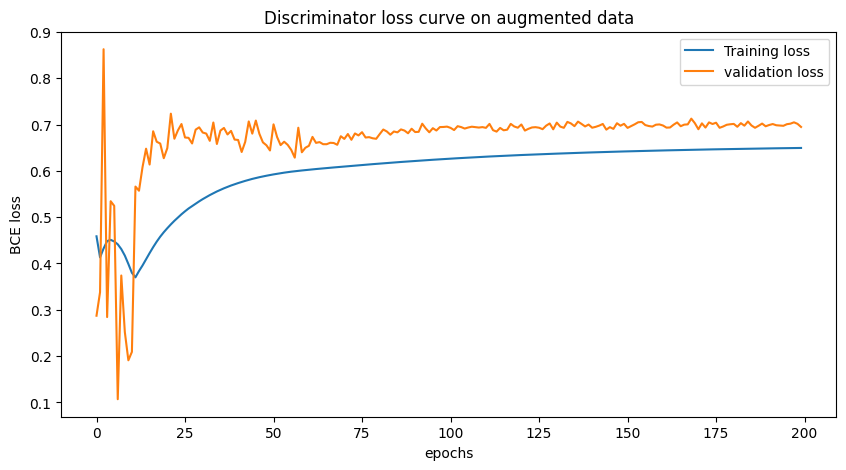

In [24]:
d_loss = history['d_loss']
val_d_loss = history['val_d_loss']

fig = plt.figure(figsize=(10, 5))

plt.plot(d_loss, label="Training loss")
plt.plot(val_d_loss, label="validation loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("BCE loss")
plt.title("Discriminator loss curve on augmented data")

if aug:
    plt.savefig("./results/discriminator_loss_aug.png", dpi=300)
    np.save('./results/d_loss_aug.npy', d_loss)
    np.save('./results/val_d_loss_aug.npy', val_d_loss)
else:
    plt.savefig("./results/discriminator_loss.png", dpi=300)
    np.save('./results/d_loss.npy', d_loss)
    np.save('./results/val_d_loss.npy', val_d_loss)
plt.show()

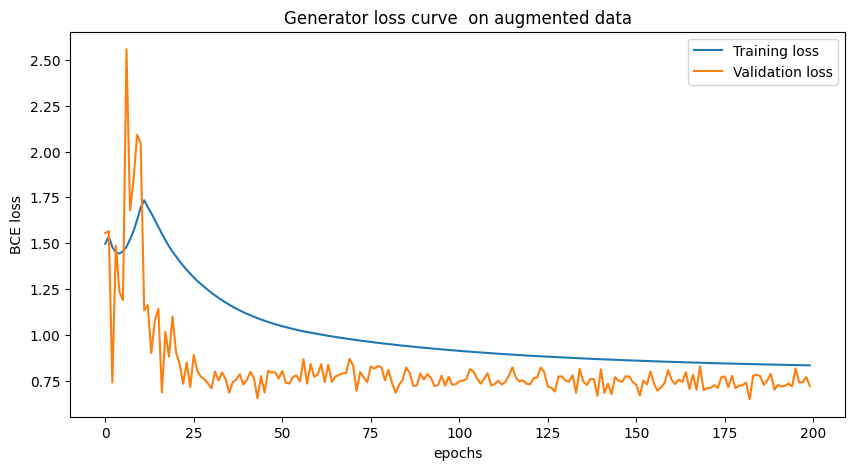

In [25]:

g_loss = history['g_loss']
val_g_loss = history['val_g_loss']

fig = plt.figure(figsize=(10, 5))

plt.plot(g_loss, label="Training loss")
plt.plot(val_g_loss, label="Validation loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("BCE loss")
plt.title("Generator loss curve  on augmented data")
if aug:
    plt.savefig("./results/generator_loss_aug.png", dpi=300)
    np.save('./results/g_loss_aug.npy', g_loss)
    np.save('./results/val_g_loss_aug.npy', val_g_loss)
else:
    plt.savefig("./results/generator_loss.png", dpi=300)
    np.save('./results/g_loss.npy', g_loss)
    np.save('./results/val_g_loss.npy', val_g_loss)
plt.show()